## Part 1 Time Series Analysis

In [53]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

### Stationarity
Differences need to be applied if data is not stationary.

C:\Users\stell\AppData\Local\Temp\ipykernel_2060\54393994.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  time_series.index = time_series.index.to_period('D')


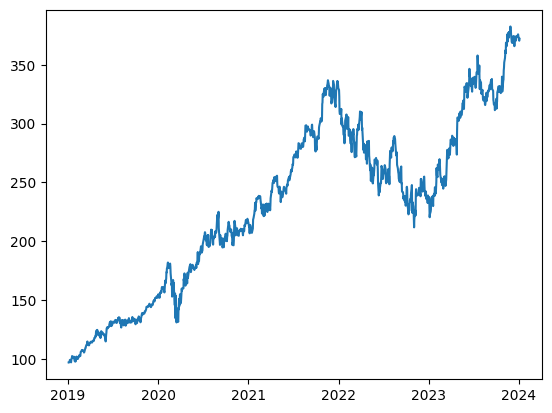

In [31]:
msft = yf.Ticker("MSFT")

# get all stock info
# msft.info

# get historical market data
df = msft.history(period='5y', interval='1d', )
df = df[['Close']].squeeze()
plt.plot(df)
time_series = df
time_series.index = time_series.index.to_period('D')

The adfuller test can help us do hypothesis testing on the stationarity

In [58]:
def adfuller_test(df):
    result=adfuller(df)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('Ho: Data is non-stationary')
    print('H1: Data is stationary')
    print()
    if result[1] <= 0.05:
        print("p < 0.05, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("p > 0.05, weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df)

ADF Test Statistic : -0.8208039499111075
p-value : 0.8129345564232588
#Lags Used : 9
Number of Observations : 1249
Ho: Data is non-stationary
H1: Data is stationary

p > 0.05, weak evidence against null hypothesis,indicating it is non-stationary 


Look at the differences, taking the first order of difference will give us stationarity

In [65]:
first_order_difference = df - df.shift(1)
adfuller_test(first_order_difference.dropna())

ADF Test Statistic : -11.578290565715383
p-value : 2.9854587759106375e-21
#Lags Used : 8
Number of Observations : 1249
Ho: Data is non-stationary
H1: Data is stationary

p < 0.05, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


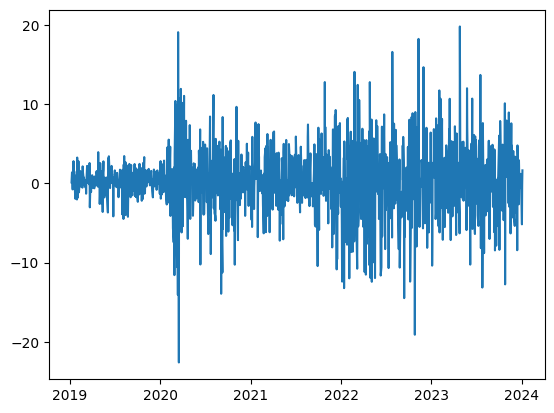

In [64]:
plt.plot(first_order_difference.index.to_timestamp(), first_order_difference.values)

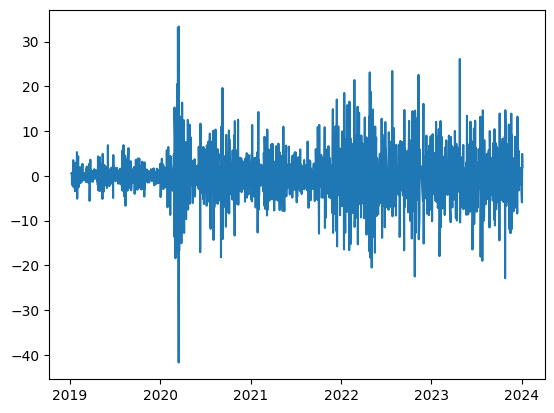

In [66]:
second_order_difference = first_order_difference - first_order_difference.shift(1)
plt.plot(second_order_difference.index.to_timestamp(), second_order_difference.values)

### Autocorrelation
This will help determine the lags to use for p. Choose a lag period which has high correlation to y.

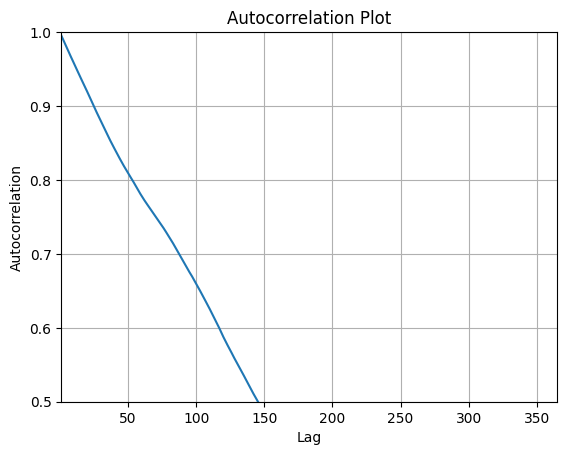

In [45]:
ax = autocorrelation_plot(time_series)
ax.set_title('Autocorrelation Plot')
ax.set_xlim(right=365)
ax.set_ylim(bottom=0.5)
plt.show()

### pdq of ARIMA
p: The lag order, representing the number of lag observations incorporated in the model.

d: Degree of differencing, denoting the number of times raw observations undergo differencing.

q: Order of moving average, indicating the size of the moving average window.


In [13]:
# From the graph above, data is not stationary, we will apply differences
p = 25
d = 1
q = 0

model = ARIMA(time_series, order=(p, d, q))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                ARIMA(25, 1, 0)   Log Likelihood               -3590.916
Date:                Thu, 04 Jan 2024   AIC                           7233.831
Time:                        23:53:41   BIC                           7367.400
Sample:                    01-04-2019   HQIC                          7284.028
                         - 01-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0865      0.022     -3.856      0.000      -0.130      -0.043
ar.L2         -0.0338      0.023     -1.451      0.147      -0.079       0.012
ar.L3         -0.0244      0.025     -0.979      0.3

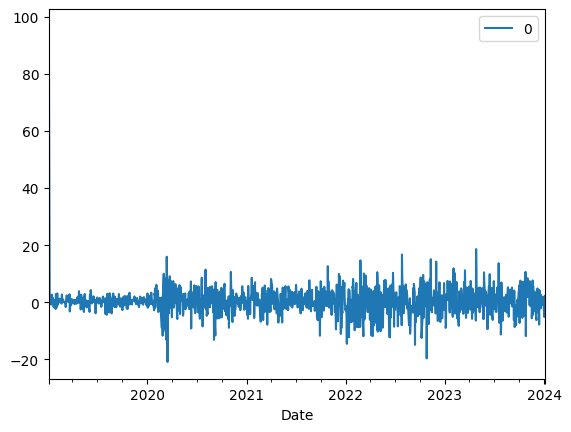

In [14]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

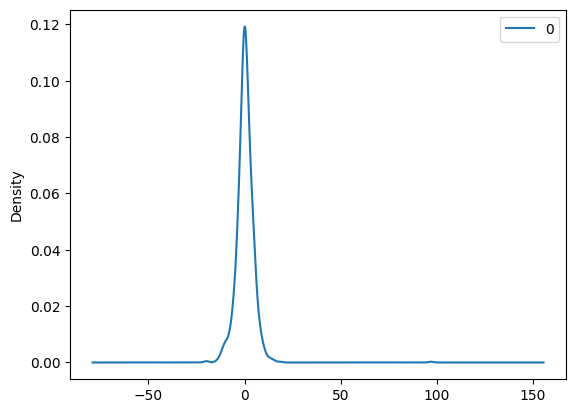

                 0
count  1259.000000
mean      0.318034
std       4.950334
min     -20.397073
25%      -1.886561
50%       0.241334
75%       2.687334
max      96.792435


In [8]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

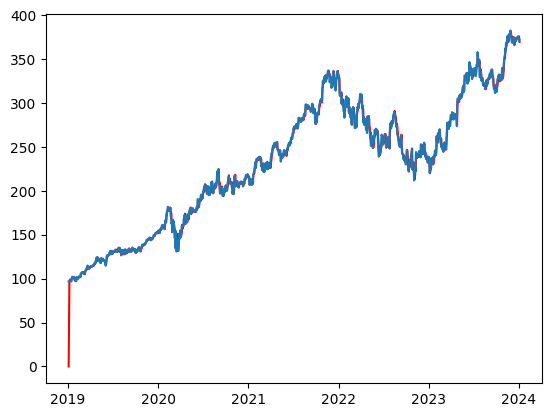

In [45]:
x = model_fit.fittedvalues.index.to_timestamp()
plt.plot(x, model_fit.fittedvalues.values, color='red')
plt.plot(df)
plt.show()

Test RMSE: 4.486


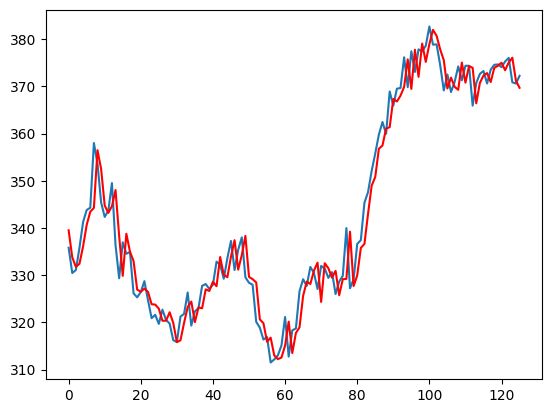

In [51]:
X = time_series.values
size = int(len(X) * 0.90)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    # Add in the actual observation and then retrain in next iteration
    obs = test[t]
    history.append(obs)
    
# evaluate forecasts
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [74]:
df.index = df.index.to_timestamp()

In [77]:
from pandas.tseries.offsets import DateOffset

future_dates=[df.index[-1]+ DateOffset(day=x) for x in range(0,30)]
future_dates

[Timestamp('2024-01-04 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-01-02 00:00:00'),
 Timestamp('2024-01-03 00:00:00'),
 Timestamp('2024-01-04 00:00:00'),
 Timestamp('2024-01-05 00:00:00'),
 Timestamp('2024-01-06 00:00:00'),
 Timestamp('2024-01-07 00:00:00'),
 Timestamp('2024-01-08 00:00:00'),
 Timestamp('2024-01-09 00:00:00'),
 Timestamp('2024-01-10 00:00:00'),
 Timestamp('2024-01-11 00:00:00'),
 Timestamp('2024-01-12 00:00:00'),
 Timestamp('2024-01-13 00:00:00'),
 Timestamp('2024-01-14 00:00:00'),
 Timestamp('2024-01-15 00:00:00'),
 Timestamp('2024-01-16 00:00:00'),
 Timestamp('2024-01-17 00:00:00'),
 Timestamp('2024-01-18 00:00:00'),
 Timestamp('2024-01-19 00:00:00'),
 Timestamp('2024-01-20 00:00:00'),
 Timestamp('2024-01-21 00:00:00'),
 Timestamp('2024-01-22 00:00:00'),
 Timestamp('2024-01-23 00:00:00'),
 Timestamp('2024-01-24 00:00:00'),
 Timestamp('2024-01-25 00:00:00'),
 Timestamp('2024-01-26 00:00:00'),
 Timestamp('2024-01-27 00:00:00'),
 Timestamp('2024-01-

In [ ]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))